# Inbalanced learn examples

 Using the module inbalanced learn to balanced our dataset (increase positives)
 To install "pip install -U imbalanced-learn" or "conda install -c glemaitre imbalanced-learn"

In [1]:
import imblearn

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets, preprocessing
from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef, roc_curve, auc, make_scorer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
import bisect
from immas import classification
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

In [2]:
# Loading of data and splitting in groups according to images
# Regions of the same image will stay in the same Pandas Dataframe in the end (dataset_df1 or dataset_df2)

# Load the dataset and groups by image filename
filename = "/Users/briannaburton/Documents/Masters/S2-Cassino/Advanced-Image-Analysis/AIA-2018/examples/feature-tables/train-data_1527086478.csv"
dataset_df1, dataset_df2 = classification.load_features_data(filename)

# Conversion from pandas dataframe to numpy array
# Keeps all the features from the original csv file
Feature = dataset_df1.drop(['class_id','img_name'], axis=1)
Target  = dataset_df1['class_id']
dataset01_data = Feature.as_matrix()
dataset01_labels = Target.as_matrix()

Feature = dataset_df2.drop(['class_id','img_name'], axis=1)
Target  = dataset_df2['class_id']
dataset02_data = Feature.as_matrix()
dataset02_labels = Target.as_matrix()

# Shuflles the datasets and creates one variable with labels for all the samples
dataset01_data, dataset01_labels = shuffle(dataset01_data, dataset01_labels, random_state=None)
dataset02_data, dataset02_labels = shuffle(dataset02_data, dataset02_labels, random_state=None)
all_data = np.vstack((dataset01_data, dataset02_data))
all_labels = np.concatenate((dataset01_labels, dataset02_labels),axis=0)

# Data standardization for each dataset (two methods)
dataset01_data = preprocessing.StandardScaler().fit_transform(dataset01_data)
dataset02_data = preprocessing.StandardScaler().fit_transform(dataset02_data)
all_data = preprocessing.StandardScaler().fit_transform(all_data)
#dataset01_data = preprocessing.robust_scale(dataset01_data)fit_transform
#dataset02_data = preprocessing.robust_scale(dataset02_data)

# Concatenates data and labels of dataset01 into one array
dataset01 = np.zeros((dataset01_data.shape[0],dataset01_data.shape[1]+1));
dataset01[:,:-1] = dataset01_data
dataset01[:,-1] = dataset01_labels

# Concatenates data and labels of dataset02 into one array
dataset02 = np.zeros((dataset02_data.shape[0],dataset02_data.shape[1]+1));
dataset02[:,:-1] = dataset02_data
dataset02[:,-1] = dataset02_labels

Number of images in the dataset 01: 205
Number of images in the dataset 02: 205
Number of regions in dataset 01: 3232
Number of regions in dataset 02: 3144


Unbalanced Data Set


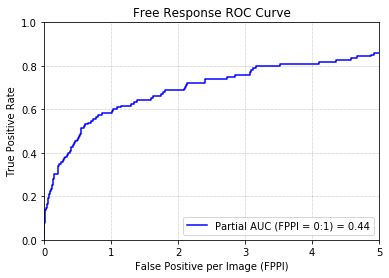

Area under the original ROC curve for our classifier: 0.90
Partial area under the FROC curve for FPPI between 0 and 1: 0.43701
RandomOverSampler


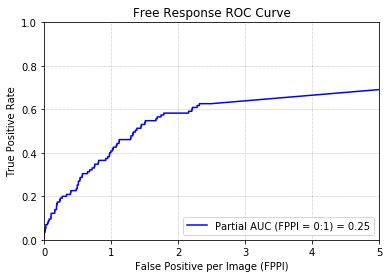

Area under the original ROC curve for our classifier: 0.77
Partial area under the FROC curve for FPPI between 0 and 1: 0.24995
ADASYN


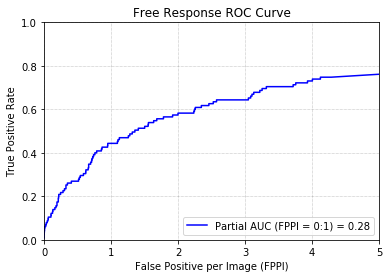

Area under the original ROC curve for our classifier: 0.80
Partial area under the FROC curve for FPPI between 0 and 1: 0.28085
SMOTE with regular algorithm


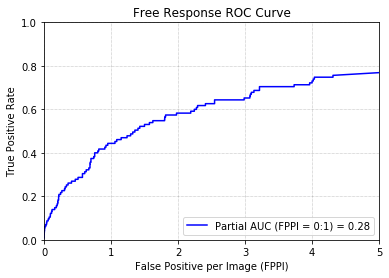

Area under the original ROC curve for our classifier: 0.80
Partial area under the FROC curve for FPPI between 0 and 1: 0.28121
SMOTE with borderline1 algorithm


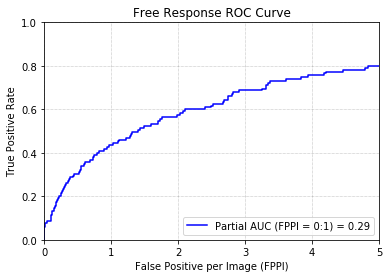

Area under the original ROC curve for our classifier: 0.85
Partial area under the FROC curve for FPPI between 0 and 1: 0.28893
SMOTE with borderline2 algorithm


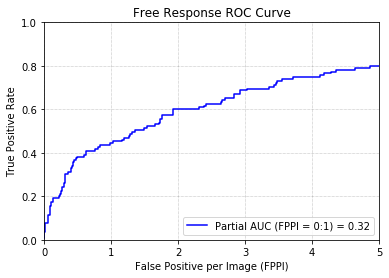

Area under the original ROC curve for our classifier: 0.85
Partial area under the FROC curve for FPPI between 0 and 1: 0.32240
SMOTE with SVM algorithm


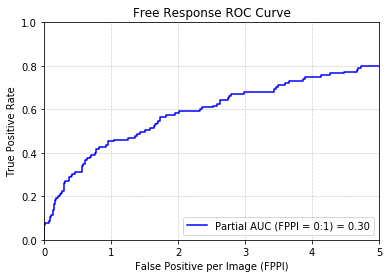

Area under the original ROC curve for our classifier: 0.85
Partial area under the FROC curve for FPPI between 0 and 1: 0.29796
SMOTEENN(random_state=42)


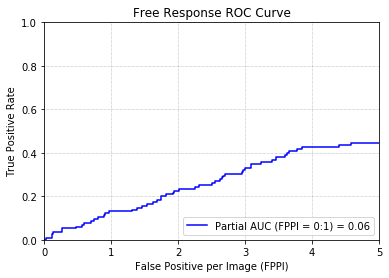

Area under the original ROC curve for our classifier: 0.61
Partial area under the FROC curve for FPPI between 0 and 1: 0.06460
SMOTETomek(random_state=42)


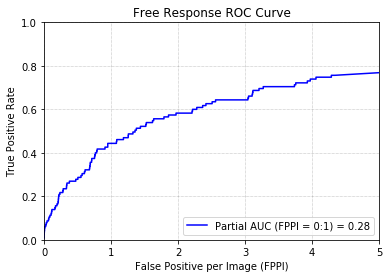

Area under the original ROC curve for our classifier: 0.80
Partial area under the FROC curve for FPPI between 0 and 1: 0.28159


In [4]:
print("Unbalanced Data Set")
_,_,_,_,_ = classification.run_SVM (dataset01, dataset02, kernel='rbf', features='all_with_LBP')
print("RandomOverSampler")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02, RandomOverSampler(random_state=0), kernel='rbf', features='all_with_LBP')
print("ADASYN")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02, ADASYN(random_state=0), kernel='rbf', features='all_with_LBP')
print("SMOTE with regular algorithm")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0), kernel='rbf', features='all_with_LBP')
print("SMOTE with borderline1 algorithm")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0, kind = 'borderline1'), kernel='rbf', features='all_with_LBP')
print("SMOTE with borderline2 algorithm")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0, kind = 'borderline2'), kernel='rbf', features='all_with_LBP')
print("SMOTE with SVM algorithm")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0, kind = 'svm'), kernel='rbf', features='all_with_LBP')
print("SMOTEENN(random_state=42)")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTEENN(random_state=42), kernel='rbf', features='all_with_LBP')
print("SMOTETomek(random_state=42)")
_,_,_,_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTETomek(random_state=42), kernel='rbf', features='all_with_LBP')

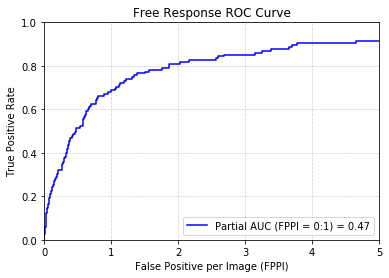

Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.47186


In [8]:
set_features = 'all_except_LBP'
save_results = np.zeros((66,2))
print("Unbalanced Data Set")
_,save_results[0,0],save_results[0,1],_,_ = classification.run_SVM (dataset01, dataset02, kernel='rbf', features='all_with_LBP')

In [9]:
# Testing for Random Over Sampler
print('random_state=0')
_,save_results[1,0],save_results[1,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02, RandomOverSampler(random_state=0), kernel='rbf', features=set_features,show_plot = 'no')
print('random_state=None')
_,save_results[2,0],save_results[2,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02, RandomOverSampler(random_state=None), kernel='rbf', features=set_features,show_plot = 'no')
print('random_state=10')
_,save_results[3,0],save_results[3,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02, RandomOverSampler(random_state=10), kernel='rbf', features=set_features,show_plot = 'no')
print("ratio ='minority', random_state=0")
_,save_results[4,0],save_results[4,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02, RandomOverSampler(ratio ='minority', random_state=0), kernel='rbf', features=set_features,show_plot = 'no')
print("ratio ='minority', random_state=None")
_,save_results[5,0],save_results[5,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02, RandomOverSampler(ratio ='minority', random_state=None), kernel='rbf', features=set_features,show_plot = 'no')

random_state=0
Area under the original ROC curve for our classifier: 0.91
Partial area under the FROC curve for FPPI between 0 and 1: 0.47332
random_state=None
Area under the original ROC curve for our classifier: 0.91
Partial area under the FROC curve for FPPI between 0 and 1: 0.47376
random_state=10
Area under the original ROC curve for our classifier: 0.91
Partial area under the FROC curve for FPPI between 0 and 1: 0.47370
ratio ='minority', random_state=0
Area under the original ROC curve for our classifier: 0.91
Partial area under the FROC curve for FPPI between 0 and 1: 0.47364
ratio ='minority', random_state=None
Area under the original ROC curve for our classifier: 0.91
Partial area under the FROC curve for FPPI between 0 and 1: 0.47359


In [10]:
# Testing for ADASYN
print('randomstate=None, n_neighbors = 1')
_,save_results[6,0],save_results[6,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02, ADASYN(random_state=None,n_neighbors = 1), kernel='rbf', features=set_features,show_plot = 'no')
print('randomstate=None, n_neighbors = 5')
_,save_results[7,0],save_results[7,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02, ADASYN(random_state=None,n_neighbors = 5), kernel='rbf', features=set_features,show_plot = 'no')
print('randomstate=None, n_neighbors = 10')
_,save_results[8,0],save_results[8,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02, ADASYN(random_state=None,n_neighbors = 10), kernel='rbf', features=set_features,show_plot = 'no')
print('randomstate=None, n_neighbors = 21')
_,save_results[9,0],save_results[9,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02, ADASYN(random_state=None,n_neighbors = 21), kernel='rbf', features=set_features,show_plot = 'no')

randomstate=None, n_neighbors = 1
Area under the original ROC curve for our classifier: 0.92
Partial area under the FROC curve for FPPI between 0 and 1: 0.52636
randomstate=None, n_neighbors = 5
Area under the original ROC curve for our classifier: 0.92
Partial area under the FROC curve for FPPI between 0 and 1: 0.51557
randomstate=None, n_neighbors = 10
Area under the original ROC curve for our classifier: 0.92
Partial area under the FROC curve for FPPI between 0 and 1: 0.52246
randomstate=None, n_neighbors = 21
Area under the original ROC curve for our classifier: 0.92
Partial area under the FROC curve for FPPI between 0 and 1: 0.51406


In [12]:
#Testing SMOTE with regular algorithm
print("random_state=0, k_neighbors=1, m_neighbors=10")
_,save_results[10,0],save_results[10,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=10")
_,save_results[11,0],save_results[11,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=10")
_,save_results[12,0],save_results[12,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=10")
_,save_results[13,0],save_results[13,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=20")
_,save_results[14,0],save_results[14,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=20), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=20")
_,save_results[15,0],save_results[15,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=20), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=20")
_,save_results[16,0],save_results[16,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=20), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=20")
_,save_results[17,0],save_results[17,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=20), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=5")
_,save_results[18,0],save_results[18,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=5")
_,save_results[19,0],save_results[19,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=5")
_,save_results[20,0],save_results[20,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=5")
_,save_results[21,0],save_results[21,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10), kernel='rbf', features=set_features,show_plot = 'no')

random_state=0, k_neighbors=1, m_neighbors=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.53569
random_state=0, k_neighbors=5, m_neighbors=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.52556
random_state=0, k_neighbors=10, m_neighbors=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.53612
random_state=0, k_neighbors=21, m_neighbors=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.53088
random_state=0, k_neighbors=1, m_neighbors=20
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.53565
random_state=0, k_neighbors=5, m_neighbors=20
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC 

In [13]:
# Testing SMOTE with borderline1 algorithm
print("random_state=0, k_neighbors=1, m_neighbors=10")
_,save_results[22,0],save_results[22,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=10")
_,save_results[23,0],save_results[23,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=10")
_,save_results[24,0],save_results[24,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=10")
_,save_results[25,0],save_results[25,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=20")
_,save_results[26,0],save_results[26,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=20,kind = 'borderline1'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=20")
_,save_results[27,0],save_results[27,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=20,kind = 'borderline1'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=20")
_,save_results[28,0],save_results[28,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=20,kind = 'borderline1'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=20")
_,save_results[29,0],save_results[29,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=20,kind = 'borderline1'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=5")
_,save_results[30,0],save_results[30,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=5")
_,save_results[31,0],save_results[31,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=5")
_,save_results[32,0],save_results[32,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=5")
_,save_results[33,0],save_results[33,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'borderline1'), kernel='rbf', features=set_features,show_plot = 'no')

random_state=0, k_neighbors=1, m_neighbors=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.50411
random_state=0, k_neighbors=5, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.55043
random_state=0, k_neighbors=10, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.56206
random_state=0, k_neighbors=21, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.56261
random_state=0, k_neighbors=1, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.53829
random_state=0, k_neighbors=5, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC 

In [14]:
# Testing SMOTE with borderline2 algorithm
print("random_state=0, k_neighbors=1, m_neighbors=10")
_,save_results[34,0],save_results[34,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=10")
_,save_results[35,0],save_results[35,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=10")
_,save_results[36,0],save_results[36,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=10")
_,save_results[37,0],save_results[37,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=20")
_,save_results[38,0],save_results[38,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=20,kind = 'borderline2'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=20")
_,save_results[39,0],save_results[39,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=20,kind = 'borderline2'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=20")
_,save_results[40,0],save_results[40,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=20,kind = 'borderline2'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=20")
_,save_results[41,0],save_results[41,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=20,kind = 'borderline2'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=5")
_,save_results[42,0],save_results[42,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=5")
_,save_results[43,0],save_results[43,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=5")
_,save_results[44,0],save_results[44,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=5")
_,save_results[45,0],save_results[45,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'borderline2'), kernel='rbf', features=set_features,show_plot = 'no')

random_state=0, k_neighbors=1, m_neighbors=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.54548
random_state=0, k_neighbors=5, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54334
random_state=0, k_neighbors=10, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.55230
random_state=0, k_neighbors=21, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.55438
random_state=0, k_neighbors=1, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.53858
random_state=0, k_neighbors=5, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC 

In [16]:
# Testing SMOTE with SVM algorithm
print("random_state=0, k_neighbors=1, m_neighbors=10")
_,save_results[46,0],save_results[46,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'svm'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=10")
_,save_results[47,0],save_results[47,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'svm'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=10")
_,save_results[48,0],save_results[48,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'svm'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=10")
_,save_results[49,0],save_results[49,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'svm'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=20")
_,save_results[50,0],save_results[50,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=20,kind = 'svm'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=20")
_,save_results[51,0],save_results[51,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=20,kind = 'svm'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=20")
_,save_results[52,0],save_results[52,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=20,kind = 'svm'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=20")
_,save_results[53,0],save_results[53,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=20,kind = 'svm'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=1, m_neighbors=5")
_,save_results[54,0],save_results[54,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=1, m_neighbors=10,kind = 'svm'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=5, m_neighbors=5")
_,save_results[55,0],save_results[55,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=5, m_neighbors=10,kind = 'svm'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=10, m_neighbors=5")
_,save_results[56,0],save_results[56,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=10, m_neighbors=10,kind = 'svm'), kernel='rbf', features=set_features,show_plot = 'no')
print("random_state=0, k_neighbors=21, m_neighbors=5")
_,save_results[57,0],save_results[57,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTE(random_state=0,k_neighbors=21, m_neighbors=10,kind = 'svm'), kernel='rbf', features=set_features,show_plot = 'no')

random_state=0, k_neighbors=1, m_neighbors=10
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.50556
random_state=0, k_neighbors=5, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.55027
random_state=0, k_neighbors=10, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.55574
random_state=0, k_neighbors=21, m_neighbors=10
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.56687
random_state=0, k_neighbors=1, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.53962
random_state=0, k_neighbors=5, m_neighbors=20
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC 

In [17]:
# Testing SMOTEENN(random_state=42)
print("with SMOTE kind regular")
_,save_results[58,0],save_results[58,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTEENN(random_state=42,smote = SMOTE(random_state=0, k_neighbors=1, m_neighbors=20)), kernel='rbf', features=set_features,show_plot = 'no')
print("with SMOTE kind borderline1")
_,save_results[59,0],save_results[59,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTEENN(random_state=42,smote = SMOTE(random_state=0, k_neighbors=1, m_neighbors=10, kind = 'borderline1')), kernel='rbf', features=set_features,show_plot = 'no')
print("with SMOTE kind borderline2")
_,save_results[60,0],save_results[60,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTEENN(random_state=42,smote = SMOTE(random_state=0, k_neighbors=5, m_neighbors=10, kind = 'borderline2')), kernel='rbf', features=set_features,show_plot = 'no')
print("with SMOTE kind svm")
_,save_results[61,0],save_results[61,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTEENN(random_state=42,smote = SMOTE(random_state=0, k_neighbors=10, m_neighbors=5, kind = 'svm')), kernel='rbf', features=set_features,show_plot = 'no')

with SMOTE kind regular
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.52836
with SMOTE kind borderline1
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.47181
with SMOTE kind borderline2
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.51007
with SMOTE kind svm
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54660


In [18]:
# Testing SMOTETomek(random_state=42)
print("with SMOTE kind regular")
_,save_results[62,0],save_results[62,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTETomek(random_state=42,smote = SMOTE(random_state=0, k_neighbors=1, m_neighbors=20)), kernel='rbf', features=set_features,show_plot = 'no')
print("with SMOTE kind borderline1")
_,save_results[63,0],save_results[63,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTETomek(random_state=42,smote = SMOTE(random_state=0, k_neighbors=1, m_neighbors=10, kind = 'borderline1')), kernel='rbf', features=set_features,show_plot = 'no')
print("with SMOTE kind borderline2")
_,save_results[64,0],save_results[64,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTETomek(random_state=42,smote = SMOTE(random_state=0, k_neighbors=5, m_neighbors=10, kind = 'borderline2')), kernel='rbf', features=set_features,show_plot = 'no')
print("with SMOTE kind svm")
_,save_results[65,0],save_results[65,1],_,_ = classification.oversampled_run_SVM (dataset01, dataset02,  SMOTETomek(random_state=42,smote = SMOTE(random_state=0, k_neighbors=10, m_neighbors=5, kind = 'svm')), kernel='rbf', features=set_features,show_plot = 'no')

with SMOTE kind regular
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.53557
with SMOTE kind borderline1
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.50189
with SMOTE kind borderline2
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54362
with SMOTE kind svm
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.55684


In [20]:
np.savetxt("SVM_notoptimized_noLBP.csv", save_results, delimiter=',')